Post Processing of Model output

In [1]:
AOI = 'gabon'
modelpath = '/Volumes/FortressL3/ANUGA/GlobalDeltas/examples/gabon/Scenarios/Elevation_ocean-GEBCO_land-GLO30_above21383m-wdpower_below21383m-plane_wetland-uni0m_lakes-uni1m/Meshes_base_50000m2/gabon_237cms_20210101_BoutBrBrBr_20220915/'

elevationpath = '/Volumes/FortressL3/ANUGA/GlobalDeltas/examples/gabon/Scenarios/Elevation_ocean-GEBCO_land-GLO30_above21383m-wdpower_below21383m-plane_wetland-uni0m_lakes-uni1m/'
elev_name = elevationpath.split('/')[-2]

print(elev_name)

Elevation_ocean-GEBCO_land-GLO30_above21383m-wdpower_below21383m-plane_wetland-uni0m_lakes-uni1m


In [2]:
import sys
import os
import pandas as pd
import shutil
from datetime import datetime
from string import Template
import fnmatch
import geopandas as gpd
import rasterio
from osgeo import gdal 

import matplotlib.pyplot as plt

import anuga
import ee 
import geemap
from pathlib import Path

In [3]:
path = (os.path.dirname(os.getcwd())) + '/'
path_code = path + 'processing/code/'
path_templates = path + 'processing/templates/'
path_examples =  '/Volumes/FortressL3/ANUGA/GlobalDeltas/examples/' 

sys.path.insert(1,path_code)
from BYOM_extra import (make_segments_for_swot)
from BYOM_Utilities_V1 import (make_watermask, build_directory)


/users/alchrist/documents/github/ANUGA/processing/code/raster_bridges.py:39: UserWarning: ShapelyDeprecationWarning
  warnings.warn('ShapelyDeprecationWarning')
/users/alchrist/documents/github/ANUGA/processing/code/raster_bridges.py:40: UserWarning: UserWarning
  warnings.warn('UserWarning')


In [4]:
working_path,folders = build_directory(path_examples, AOI)





##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/Volumes/FortressL3/ANUGA/GlobalDeltas/examples/gabon/ 

[Step 1][Build Directory] Finished .......



In [18]:
Path((path_examples + AOI)).mkdir(parents=True, exist_ok=True)

parameters  = pd.read_csv( modelpath + '/config_gabon_20220915.csv',dtype=str,delimiter=',')


In [6]:
## STEP 5
## Make river and ocean segments for SWOT simulator
## Approximately 900m for river segments and 10000m2 for oceans
ulx  = parameters['ulx'][0]                                                 # ULX coordinate
lry  = parameters['lry'][0]                                                 # LRY coordinate
lrx  = parameters['lrx'][0]                                                 # LRX coordinate
uly  = parameters['uly'][0]                                                 # ULY coordinate

swot_res = 90
pixel_step = int(round(90/swot_res))
target_segment_size = 10000
scale = 1
sigma = 0.95


try:
    dem = rasterio.open(elevationpath + '/' + elev_name + '_' + str(swot_res) + '.tif')
except:
    os.system('gdalwarp -overwrite -tr %s %s %s/%s_%s.tif %s/%s_%s_%s.tif '\
                  ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
                  %(swot_res,swot_res,elevationpath,AOI,elev_name,elevationpath,AOI,elev_name,swot_res,ulx,lry,lrx,uly))
    dem = rasterio.open(elevationpath + '/' + AOI + '_' + elev_name + '_' + str(swot_res) + '.tif')



In [7]:
if os.path.isfile('%s/%s_watermask_%s.tif' %(folders[7],AOI,swot_res)) == False:
    
    os.system('gdalwarp -overwrite -tr %s %s %s/%s_watermask_%s.tif %s/%s_watermask_%s.tif '\
                  ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
                  %(swot_res,swot_res,folders[7],AOI,10,folders[7],AOI,swot_res,ulx,lry,lrx,uly))
 



##############################################################################################
#############################[Step 6][Make_Segments_For_SWOT]################################
##############################################################################################

0...10...20...30...40...50...60...70...80...90...100 - done.


ERROR 5: Source and destination datasets must be different.

ERROR 5: Source and destination datasets must be different.



[Step 6][Making ocean segments using skimage segmentation] ......
##################### Superpixel area will be 10000m
##################### # slic segments will be 412051
0...10...20...30...40...50...60...70...80...90...Creating output /Volumes/FortressL3/ANUGA/GlobalDeltas/examples/gabon/Setup_Files/Setup_SHP/gabon_oceanriver_bathy_superpixels_10000m2_compact0.0001_segs10_slic.shp of format ESRI Shapefile.
100 - done.
0...10...20...30...40...50...60...70...80...90...Creating output /Volumes/FortressL3/ANUGA/GlobalDeltas/examples/gabon/Setup_Files/Setup_SHP/gabon_oceanriver_bathy_superpixels_10000m2_compact0.0001_segs100_slic.shp of format ESRI Shapefile.
100 - done.
0...10...20...30...40...50...60...70...80...90...Creating output /Volumes/FortressL3/ANUGA/GlobalDeltas/examples/gabon/Setup_Files/Setup_SHP/gabon_oceanriver_bathy_superpixels_10000m2_compact0.0001_segs1000_slic.shp of format ESRI Shapefile.
100 - done.
0...10...20...30...40...50...60...70...80...90...Creating output /Vol

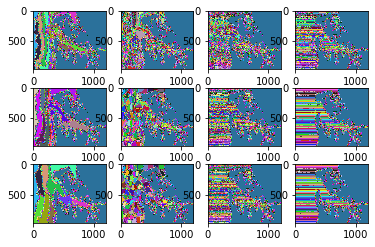

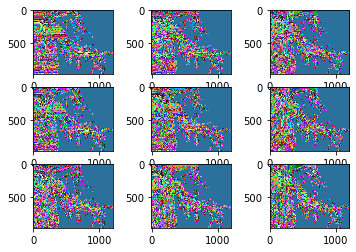

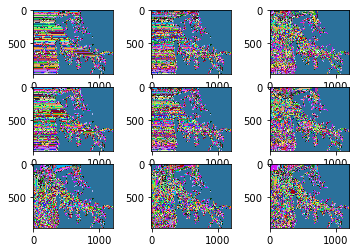

In [8]:

make_segments_for_swot(folders,AOI,dem,parameters,pixel_step,target_segment_size,scale,sigma,os.path.isfile('%s%s_oceanriver_bathy_superpixels_%sm2_%s_%s_felz_SWOTb.shp'%(folders[6],AOI,target_segment_size,scale,sigma)))#,10,0.01)


In [10]:
extentfile = gpd.read_file('%s%s_input.shp' %(folders[0],AOI))
extentfile.crs = 'EPSG:4326'

scenario = 'gabon_237cms_20210101_Meshes_base_50000m2_BoutBrBrBr'

Path('%s/outputRST' %(modelpath)).mkdir(parents=True, exist_ok=True)
Path('%s/outputRST/abselev'%( modelpath)).mkdir(parents=True, exist_ok=True)
Path('%s/outputRST/depth'%( modelpath)).mkdir(parents=True, exist_ok=True)
Path('%s/outputRST/stage'%( modelpath)).mkdir(parents=True, exist_ok=True)
Path('%s/outputRST/waterelev'%( modelpath)).mkdir(parents=True, exist_ok=True)
Path('%s/outputRST/flooded'%( modelpath)).mkdir(parents=True, exist_ok=True)

cnespath =  modelpath + '/SWOT_simulator'
Path(cnespath).mkdir(parents=True, exist_ok=True)
print('CNES SWOT simulator files will be here: %s' %(cnespath))


CNES SWOT simulator files will be here: /Volumes/FortressL3/ANUGA/GlobalDeltas/examples/gabon/Scenarios/Elevation_ocean-GEBCO_land-GLO30_above21383m-wdpower_below21383m-plane_wetland-uni0m_lakes-uni1m/Meshes_base_50000m2/gabon_237cms_20210101_BoutBrBrBr_20220915//SWOT_simulator


In [19]:
from delta_swot_simulations import make_model_output_rasters, get_orbit_files , run_swot_simulator
nowtime = '20220915'
print('\n\n Making model output rasters for last 8 2-hr timesteps\n\n')
make_model_output_rasters(working_path, path_code,scenario, modelpath,folders,cnespath,nowtime,parameters,path_templates,False)




 Making model output rasters for last 8 2-hr timesteps


Extract bed elevation from SWW file
Resampled to 100 m resolution
Reading sww File ...
Extracting required data ...
Computing grid of output locations...
Making interpolation functions...
Reduction =  0
elevation
Making raster ...

Extract time series of stage from SWW file
Reading sww File ...


IndexError: index 128 is out of bounds for axis 0 with size 26

In [ ]:
pixel_step = 4
sword_res = 10
sword_ref = rasterio.open('%s%s_GEBCO_%s.tif' %(folders[7],AOI,sword_res))


os.system('gdalwarp -overwrite -tr %s %s %s/%s_%s.tif %s/%s_%s.tif '\
                  ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
                  %(swot_res,swot_res,folders[7],AOI,10,folders[7],AOI,sword_res,ulx,lry,lrx,uly))
 
if (os.path.isfile("%s%s_river_centerline_%s.shp" %(folders[6],AOI,int(sword_res*pixel_step)))==False) & (os.path.isfile("%s%s_river_centerline_%s.shp" %(folders[6],AOI,int(sword_res*(pixel_step+1))))==False):
    try: distance = make_SWORD_networks(folders,sword_ref,AOI,parameters,pixel_step,watermaskname,False)
    except:
        distance = make_SWORD_networks(folders,sword_ref,AOI,parameters,pixel_step+1,watermaskname,False)
